# Malaria Detection

## Machine Learning Development life cycle  
1. Task  
2. Data Preparation  
3. Modelling
4. Error Measurement
5. Training and Optimization
6. Performance Measurement
7. Validating and Testing
8. Corrective Measures

Using Python 3.8.18

In [96]:
import tensorflow as tf 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds 
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, InputLayer, Flatten, BatchNormalization, Input, Layer
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow import keras
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, AUC, Precision, Recall
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

## Data Preparation


![Dataset split](../images/Dataset_Split.png "Dataset split")  
The split of this dataset is only "Train", so we can't have "Test"

In [97]:
dataset, dataset_info = tfds.load("malaria", with_info = True, shuffle_files=True, as_supervised=True, split=["train"])

In [98]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [99]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/Users/cheesemac/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin bl

In [100]:
for data in dataset[0].take(5):
    print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [101]:
print(len(dataset[0]))

27558


Now we define a `splits()` function to split our dataset into train, validation and test sets with given ratios, using `take()` and `skip()`

In [102]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))

    val_dataset = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
    val_dataset = val_dataset.take(int(DATASET_SIZE*VAL_RATIO))

    test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO + VAL_RATIO)))

    return train_dataset, val_dataset, test_dataset

Looking at the picture about the splits of this dataset, we should note that this dataset is of type `list`, in order to access the data, we have to go to index `0`, so `dataset[0]`

In [103]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 1 - (TRAIN_RATIO + VAL_RATIO)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
TRAIN_DATASET_SIZE = len(train_dataset)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2755
2756


In [104]:
print(list(val_dataset.take(5).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

In [105]:
for data in val_dataset.take(16):
    print(data)

(<tf.Tensor: shape=(124, 139, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(130, 124, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

## Dataset Visualization

In [106]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/Users/cheesemac/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin bl

Looking at `"label"`, we can see that it is of `ClassLabel()` feature, with `num_classes = 2` meaning that it contains 2 classes. Labels are stored as integers in the dataset. When you retrieve the labels, `ClassLabel.int2str()` and `ClassLabel.str2int()` carries out the conversion from integer value to label name, and vice versa.  

There is also `Value()` feature.

*Referenced from:* https://huggingface.co/docs/datasets/about_dataset_features

Using `plt.subplot`

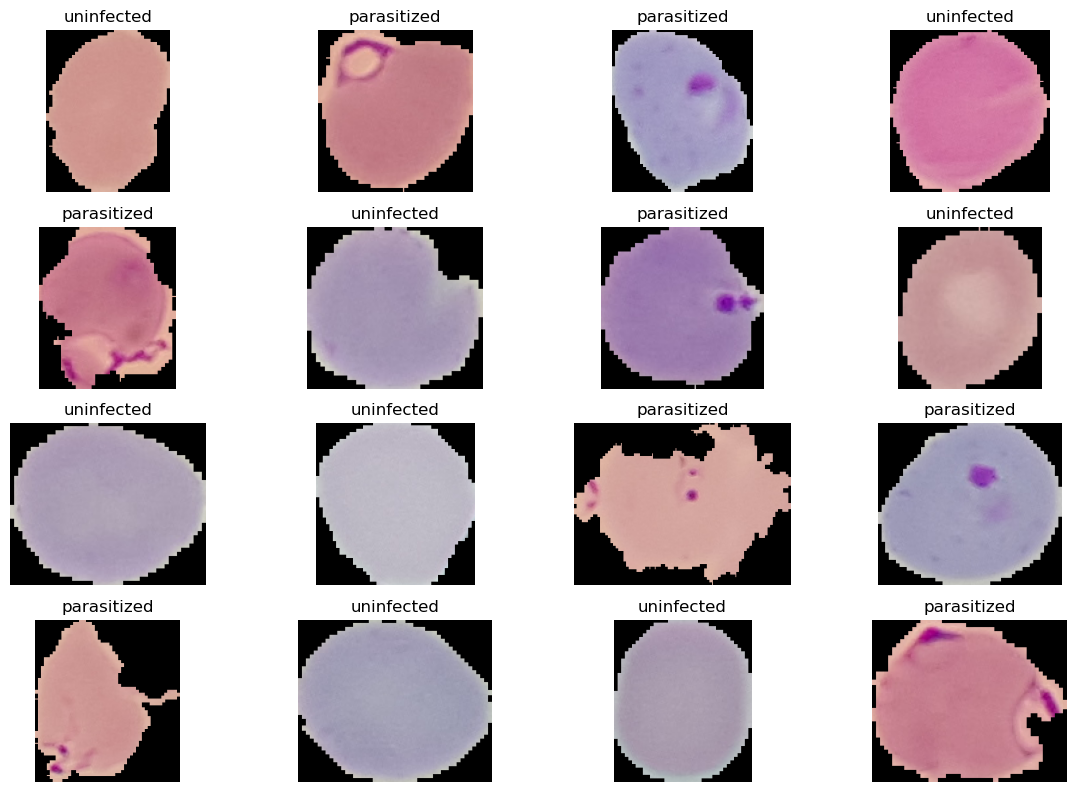

In [107]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(train_dataset.take(16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

plt.tight_layout(pad=1)

## Data Processing

When do we use stadardization, and when normalization?  
* We use standardization when the data in our dataset lie mainly around a mean with standard deviation.
* We use normalization when the data in our dataset are mainly different and is distributed fairly randomly within a range (min, max)

That explains why normalization is a better suit for this dataset, since the values lie between 0 and 255 and are faily random. In this case, our normalization formula is going to be `(x - x_min)/(x_max - x_min) = x / 255`

First, we need to resize our images to have an uniform size

We will use `map()` attribute to apply a resizing function to our dataset. But since this attribute only return our image and not our label, which is also needed to assign to our dataset, we will first define a resizing function

In [108]:
IMG_SIZE = 224
def resize_normalize(img, label):
    return tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255, label

In [109]:
train_dataset = train_dataset.map(resize_normalize)
val_dataset = val_dataset.map(resize_normalize)
test_dataset = test_dataset.map(resize_normalize)

In [110]:
for image, label in val_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


The data type of `resize_normalize(img, label)[0]` is kind of like a list or an array, that's why we can broadcast like `tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255` in the function `resize_normalize`

In [111]:
for img, label in train_dataset.take(1):
    print(list(resize_normalize(img, label)[0]))

[<tf.Tensor: shape=(224, 3), dtype=float32, numpy=
array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
    

In [112]:
BUFFER_SIZE = 300
BATCH_SIZE = 200
train_dataset = train_dataset.shuffle(buffer_size= BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Design

### Convolutional Neural Network (CNN)
For better visualization: https://poloclub.github.io/cnn-explainer/  
Note for padding: When using padding, we have to ensure that the outer layers (especially the corners) still have impact on the data

Padding is especially useful when the actual image is located somewhere in the outer layer. When padding, the cursor with given kernel size will go through the image more times.  

`output = (input + 2 * Padding - Kernel)/Stride + 1`


***How CNN works:***  

 ![CNN Visualization](../images/CNN.png "CNN Visualization")  

 With the kernel, padding and stride specified, the kernel will now parse through the input of all dimensions, multiply by a *filter* and take the sum of all the results to be the output value at the corresponding position.  

 The filter is a matrix of the same size with the kernel. There are pre-existing filters like outline, sharpen or blur etc.  
 
 ![Outline filter](../images/Filter.png "Outline filter")  
 Visual source: https://setosa.io/ev/image-kernels/
 
 But in CNN, we don't specify the filter. We just initialize the initial filter matrix, and let the model decide for themselves.  

***LeNet and AlexNet***  

![LeNet and AlexNet](../images/AlexNet_Lenet.png "LeNet and AlexNet")  
Visual source: https://en.wikipedia.org/wiki/AlexNet  

Explanation on how to get outputs:  
![Output](../images/Output.png "Output")  

If the image has size 64x64x3 (RGB), when applied to a filter 5x5 like in the illustration shown above, will have an output of shape AxAx1, in order to get something like AxAx6, we have to have 6 filters, and then stack the output on each other (into ***channels***).  

Moreover, for each filter, after multiplying the input to the filter, we have to add the bias. In total, we would have 6 biases.  

Parameters to be trained: **(3 x 5 x 5) x 6 + 6 = 456** parameters to be trained

**Pooling Layers**  

Pooling layer summarises the features present in regions of the output map generated by the CNN, and reduces the dimension of the input to the next layer  

To reduce the dimension to a half, we pick the size of filter (kernel) to be 2, and stride 2, because then `output = (input - kernel) / stride + 1 = (input - 2) / 2 + 1 = input / 2`

### Sequential API

In [113]:
# lenet_model = Sequential([
#     InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

#     Conv2D(filters = 6, kernel_size = 4, padding = "valid", activation = "relu"),
#     BatchNormalization(),
#     MaxPool2D(pool_size = 2, strides=2),

#     Conv2D(filters = 16, kernel_size = 4, padding = "valid", activation = "relu"),
#     BatchNormalization(),
#     MaxPool2D(pool_size = 2, strides=2),

#     Flatten(),

#     Dense(100, activation = "relu"),
#     BatchNormalization(),

#     Dense(10, activation = "relu"),
#     BatchNormalization(), 

#     Dense(1, activation = "sigmoid")
# ])

# lenet_model.summary()

### Functional API 

There is another way to create our model, that is using Functional API. The essence of using Functional API is, well, treating the model and its components like a function.  

We can simply take the whole configuration that we had for Sequential API and edit it a bit to use Functional API. What I like to do here, however, is to have the feature extracting bit of the model being in Sequential API and use it again later.

In [114]:
# feature_extracting_seq = Sequential([
#     InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

#     Conv2D(filters = 6, kernel_size = 4, padding = "valid", activation = "relu"),
#     BatchNormalization(),
#     MaxPool2D(pool_size = 2, strides=2),

#     Conv2D(filters = 16, kernel_size = 4, padding = "valid", activation = "relu"),
#     BatchNormalization(),
#     MaxPool2D(pool_size = 2, strides=2)
# ])
# feature_extracting_seq.summary()

In [115]:
# func_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="Input_Image")

# x = feature_extracting_seq(func_input)

# x = Flatten()(x)

# x = Dense(100, activation = "relu")(x)
# x = BatchNormalization()(x)

# x = Dense(10, activation = "relu")(x)
# x = BatchNormalization()(x)

# func_output = Dense(1, activation = "sigmoid")(x)

# lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
# lenet_model_func.summary()

For `metrics`, we are using `"accuracy"`, which is a metric which measures the frequency (num of correct predictions / total num of predictions) of the model predicting the outcome correctly, which is well suited for this type of classification problem

### Subclassing

Another way to configure our model is to make use of inheritance.

Refer to https://realpython.com/python-super/#an-overview-of-pythons-super-function to learn more about `super()` in Python, and why we don't need parameters here

In [116]:
# class FeatureExtractor(Model):
#     def __init__(self):
#         super().__init__()

#         self.conv_1 = Conv2D(filters = 6, kernel_size = 4, padding = "valid", activation = "relu")
#         self.batchnorm_1 = BatchNormalization()
#         self.maxpool_1 = MaxPool2D(pool_size = 2, strides=2)

#         self.conv_2 = Conv2D(filters = 16, kernel_size = 4, padding = "valid", activation = "relu")
#         self.batchnorm_2 = BatchNormalization()
#         self.maxpool_2 = MaxPool2D(pool_size = 2, strides=2)

#     def call(self, x):
#         x = self.conv_1(x)
#         x = self.batchnorm_1(x)
#         x = self.maxpool_1(x)

#         x = self.conv_2(x)
#         x = self.batchnorm_2(x)
#         x = self.maxpool_2(x)

#         return x

In [117]:
# feature_extractor = FeatureExtractor()

In [118]:
# class LenetModel(Model):
#     def __init__(self):
#         super().__init__()

#         self.feature_extractor = feature_extractor
#         self.flatten = Flatten()

#         self.dense_1 = Dense(100, activation = "relu")
#         self.batchnorm_1 = BatchNormalization()

#         self.dense_2 = Dense(10, activation = "relu")
#         self.batchnorm_2 = BatchNormalization()

#         self.dense_output = Dense(1, activation = "sigmoid")

#     def call(self, x):
#         x = self.feature_extractor(x)
#         x = self.flatten(x)

#         x = self.dense_1(x)
#         x = self.batchnorm_1(x)

#         x = self.dense_2(x)
#         x = self.batchnorm_2(x)

#         x = self.dense_output(x)

#         return x

In order to do `lenet_model_subclassing.summary()`, we first have to build our model or feed it with a batch of data. The second line of code is to feed it with a batch of data, which explains why we have the 1 in `[1, IMG_SIZE, IMG_SIZE, 3]`, which indicates a batch of size 1

In [119]:
# lenet_model_subclassing = LenetModel()
# lenet_model_subclassing(tf.zeros([1, IMG_SIZE, IMG_SIZE, 3]))
# lenet_model_subclassing.summary()

### Custom Layer  

Reference: [Custom Layers in Tensorflow](https://www.tensorflow.org/tutorials/customization/custom_layers)  

Things to implement:
1) `__init__` , where you can do all input-independent initialization
2) `build`, where you know the shapes of the input tensors and can do the rest of the initialization
3) `call`, where you do the forward computation  

We don't have to wait until `build` to initialize our variables. However, the advantage of creating them in `build` is that it enables late variable creation based on the shape of the inputs the layer will operate on.

In the [Tensorflow's documentation of its Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), we can see that the initializer for weights (`kernel_initializer`) is `"glorot_uniform"` and for biases (`bias_initializer`) is `"zeros"` (a matrix consisting solely of zeros), while in our `NewDense`, we use `"random_normal"` for both our bias and weights initializer. This results in a slight difference in our training accuracy and loss

In [120]:
class NewDense(Layer):
    def __init__(self, output_units, activation):
        super().__init__()

        self.output_units = output_units
        self.activation = activation

    def build(self, input_features_shape):
        self.w = self.add_weight(name = "weights", shape = (input_features_shape[-1], self.output_units), trainable = True, initializer = "random_normal")
        self.b = self.add_weight(name = "biases", shape = (self.output_units,), trainable = True, initializer = "random_normal")

    def call(self, input_features):
        z = tf.matmul(input_features, self.w) + self.b
        if self.activation == "sigmoid":
            return tf.keras.activations.sigmoid(z)
        elif self.activation == "relu":
            return tf.keras.activations.relu(z)
        return tf.keras.activations.linear(z)

In [121]:
lenet_model_custom_layer = Sequential([
    InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 4, padding = "valid", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    Conv2D(filters = 16, kernel_size = 4, padding = "valid", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    Flatten(),

    NewDense(100, activation = "relu"),
    BatchNormalization(),

    NewDense(10, activation = "relu"),
    BatchNormalization(), 

    NewDense(1, activation = "sigmoid")
])

lenet_model_custom_layer.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 221, 221, 6)       294       
                                                                 
 batch_normalization_8 (Bat  (None, 221, 221, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 107, 107, 16)      1552      
                                                                 
 batch_normalization_9 (Bat  (None, 107, 107, 16)      64        
 chNormalization)                                                
                                                      

## Model Training

### Metrics for binary classification

#### Types of metrics
For detailed reference, visit [this blog](https://arize.com/blog-course/f1-score/)

**1)** Precision = (True Positive) / (All Predicted Positive) = TP / (TP + FP)  

**2)** Recall ***(True Positive Rate)*** = (True Positive) / (All Positive) = TP / (TP + FN)  

*Note:*  

Difference between Precision and Recall lies in FP and FN. If we specifically want a **low/high Precision, then we need to have a high/low number of FP** and if we specifically **want a low/high Recall, we need to have a high/low number of FN.**  
  
In our case, we want to minimise the number of FN, which means that we need to maximise the Recall.  

*Note:*  

Since the total number of positives (TP + FN) is constant, a **low recall indicates that the model isn't able to find any positive case**

**3)** Accuracy = (True Predictions) / (All Predictions) = (TP + TN) / (TP + TN + FP + FN)  

*Note:* As we can see here, Accuracy treats FP and FN all the same

**4)** F1-score = 2 * (Precision * Recall) / (Precision + Recall)  

F1-score ranges from 0 to 1, with 1 representing a model that perfectly classifies each observation into the correct class and 0 representing a model that is unable to classify any observation into the correct class. The more the Precision and Recall deviate from each other, the worse F1-score will be.  

**5)** Specificity ***(True Negative Rate)*** = (True Negative) / (All negative) = TN / (TN + FP)  

Specificity is basically Recall but with offset in correcting predicting negative values.

**Conclusion:**  
* Precision and Recall are used to evaluate the model's performance in predicting FP and FN respectively  

* Accuracy treats FP and FN all the same (generic, works poorly in a lot of real-world datasets)  

For example: As a general rule, fraud accounts for a relatively small portion of transactions in the real world. In healthcare billing, for example, fraud is estimated to be 3% of total transactions. As a result, traditional accuracy metrics can be misleading. F1 score can be useful in such cases.  

* F1-score measures how good the model is at identifying both positive and negative cases

**False Positive Rate** = (False Positive) / (All Negative) = FP / (FP + TN)

#### ROC plot

![ROC plot](../images/ROC_plot.png "ROC plot")

#### AUC

![AUC](../images/AUC.svg "AUC")

The higher the AUC, the better the model, since according to the ROC plots when comparing them, the model with higher AUC has better options to choose from (good balance between TP and FP)

### Callbacks

#### Loss Callbacks

In [122]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nEpoch {} has a loss of {}".format(epoch + 1, logs["loss"]))

    def on_batch_end(self, batch, logs):
        print("\nBatch {} has {}".format(batch + 1, logs))

#### CSV Logger

In [123]:
csv_logger = CSVLogger("training.csv", separator=",", append = False)

#### Early Stopping

In [124]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='max',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

#### Learning rate scheduling

##### Step Decay
$$\alpha = \alpha_0 * d^{floor((1 + epoch) / step)}$$
* $\alpha_0$: initial learning rate  
* $d$: decay rate  
* $step$: after how many epochs should the learning rate be scaled down  

This learning rate scheduler scales $\alpha$ down by a factor of $d$ after $step$ epochs  

##### Exponential Decay
$$\alpha = \alpha_0 * e^{-k * epoch}$$  
* $k$: decay rate  

This learning rate scheduler scales $\alpha$ down exponentially  

##### Cosine Annealing  
$$\alpha = \alpha_{min} + 0.5*(\alpha_{max} - \alpha_{min})*(1+cos(\frac{epoch}{epoch_{max}}*\pi))$$  
* $\alpha_{min}$: minimum learning rate  
* $\alpha_{max}$: maximum learning rate  
* $epoch_{max}$: maximum epoch

In [125]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [126]:
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

#### Model Checkpointing

`save_freq` = `"epoch"` (checkpoint for each epoch) or an integer (number of batches), that's why here we have to calculate `batches_in_epoch`

In [127]:
batches_in_epoch = math.floor(TRAIN_DATASET_SIZE / BATCH_SIZE)
checkpoint = ModelCheckpoint(
    "Checkpoints/",
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only= False,
    save_weights_only = False,
    mode = 'auto',
    save_freq= 3 * batches_in_epoch
)

#### Reduce Learning Rate on Plateau

In [128]:
lr_plateau = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=1,
    min_delta=0.01,
    min_lr=0,
)

In [129]:
callback_list = [lr_plateau, 
                 checkpoint, 
                 csv_logger, 
                 early_stop, 
                 #lr_scheduler
                 ]

## Model with new metrics

In [130]:
metrics = [TruePositives(name = "tp"), 
           TrueNegatives(name = "tn"), 
           FalseNegatives(name = "fn"), 
           FalsePositives(name = "fp"),
           Precision(name = "precision"),
           Recall(name = "recall"),
           BinaryAccuracy(name = "accuracy"),
           AUC(name = "auc")]

In [131]:
lenet_model_custom_layer.compile(optimizer=Adam(learning_rate=0.004),
              loss = BinaryCrossentropy(from_logits=False),
              metrics = metrics)

In [132]:
# sess = tf.compat.v1.Session(config=config)
# process = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)

**Hint:** The fact that this error is thrown after the first epoch was thrown means that the problem probably lies in the `val_dataset`

In [133]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [134]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

We can see that we haven't yet resize our `val_dataset`. Let's go resize and normalize our `val_dataset` and try again.

In [135]:
process = lenet_model_custom_layer.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1, callbacks=callback_list)

Epoch 1/20


2024-02-22 18:50:19.513687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - ETA: 0s - loss: 0.4221 - tp: 9101.0000 - tn: 8468.0000 - fn: 1922.0000 - fp: 2555.0000 - precision: 0.7808 - recall: 0.8256 - accuracy: 0.7969 - auc: 0.8888

2024-02-22 18:50:38.322391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 22s 183ms/step - loss: 0.4221 - tp: 9101.0000 - tn: 8468.0000 - fn: 1922.0000 - fp: 2555.0000 - precision: 0.7808 - recall: 0.8256 - accuracy: 0.7969 - auc: 0.8888 - val_loss: 2.4013 - val_tp: 0.0000e+00 - val_tn: 1367.0000 - val_fn: 1388.0000 - val_fp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.4962 - val_auc: 0.6601 - lr: 0.0040
Epoch 2/20
111/111 [==============================] - 20s 177ms/step - loss: 0.1936 - tp: 10465.0000 - tn: 10083.0000 - fn: 558.0000 - fp: 940.0000 - precision: 0.9176 - recall: 0.9494 - accuracy: 0.9321 - auc: 0.9744 - val_loss: 1.1644 - val_tp: 113.0000 - val_tn: 1360.0000 - val_fn: 1279.0000 - val_fp: 3.0000 - val_precision: 0.9741 - val_recall: 0.0812 - val_accuracy: 0.5347 - val_auc: 0.8737 - lr: 0.0040
Epoch 3/20
107/111 [===========================>..] - ETA: 0s - loss: 0.1554 - tp: 10290.0000 - tn: 9941.0000 - fn: 416.0000 - fp: 753.0000 - precision: 0.9318 - recall: 0.9

INFO:tensorflow:Assets written to: Checkpoints/assets


111/111 [==============================] - 20s 183ms/step - loss: 0.1544 - tp: 10604.0000 - tn: 10247.0000 - fn: 422.0000 - fp: 773.0000 - precision: 0.9321 - recall: 0.9617 - accuracy: 0.9458 - auc: 0.9831 - val_loss: 0.2927 - val_tp: 1213.0000 - val_tn: 1216.0000 - val_fn: 179.0000 - val_fp: 147.0000 - val_precision: 0.8919 - val_recall: 0.8714 - val_accuracy: 0.8817 - val_auc: 0.9460 - lr: 0.0040
Epoch 4/20
111/111 [==============================] - 20s 177ms/step - loss: 0.1390 - tp: 10606.0000 - tn: 10289.0000 - fn: 419.0000 - fp: 732.0000 - precision: 0.9354 - recall: 0.9620 - accuracy: 0.9478 - auc: 0.9868 - val_loss: 0.5097 - val_tp: 756.0000 - val_tn: 1293.0000 - val_fn: 639.0000 - val_fp: 67.0000 - val_precision: 0.9186 - val_recall: 0.5419 - val_accuracy: 0.7437 - val_auc: 0.9399 - lr: 0.0040
Epoch 5/20
111/111 [==============================] - 20s 177ms/step - loss: 0.1132 - tp: 10704.0000 - tn: 10426.0000 - fn: 321.0000 - fp: 595.0000 - precision: 0.9473 - recall: 0.9709 

INFO:tensorflow:Assets written to: Checkpoints/assets


111/111 [==============================] - 20s 181ms/step - loss: 0.0969 - tp: 10724.0000 - tn: 10513.0000 - fn: 304.0000 - fp: 505.0000 - precision: 0.9550 - recall: 0.9724 - accuracy: 0.9633 - auc: 0.9934 - val_loss: 0.2138 - val_tp: 1272.0000 - val_tn: 1280.0000 - val_fn: 123.0000 - val_fp: 80.0000 - val_precision: 0.9408 - val_recall: 0.9118 - val_accuracy: 0.9263 - val_auc: 0.9758 - lr: 0.0040
Epoch 7/20
111/111 [==============================] - 20s 177ms/step - loss: 0.0844 - tp: 10764.0000 - tn: 10576.0000 - fn: 259.0000 - fp: 447.0000 - precision: 0.9601 - recall: 0.9765 - accuracy: 0.9680 - auc: 0.9949 - val_loss: 0.3651 - val_tp: 1007.0000 - val_tn: 1332.0000 - val_fn: 387.0000 - val_fp: 29.0000 - val_precision: 0.9720 - val_recall: 0.7224 - val_accuracy: 0.8490 - val_auc: 0.9729 - lr: 0.0040
Epoch 8/20
111/111 [==============================] - ETA: 0s - loss: 0.0636 - tp: 10844.0000 - tn: 10704.0000 - fn: 179.0000 - fp: 319.0000 - precision: 0.9714 - recall: 0.9838 - accur

INFO:tensorflow:Assets written to: Checkpoints/assets


111/111 [==============================] - 20s 177ms/step - loss: 0.0390 - tp: 10915.0000 - tn: 10850.0000 - fn: 109.0000 - fp: 172.0000 - precision: 0.9845 - recall: 0.9901 - accuracy: 0.9873 - auc: 0.9988 - val_loss: 0.1597 - val_tp: 1323.0000 - val_tn: 1300.0000 - val_fn: 72.0000 - val_fp: 60.0000 - val_precision: 0.9566 - val_recall: 0.9484 - val_accuracy: 0.9521 - val_auc: 0.9832 - lr: 4.0000e-04
Epoch 10/20
111/111 [==============================] - 19s 170ms/step - loss: 0.0293 - tp: 10959.0000 - tn: 10880.0000 - fn: 65.0000 - fp: 142.0000 - precision: 0.9872 - recall: 0.9941 - accuracy: 0.9906 - auc: 0.9994 - val_loss: 0.1658 - val_tp: 1342.0000 - val_tn: 1292.0000 - val_fn: 54.0000 - val_fp: 67.0000 - val_precision: 0.9524 - val_recall: 0.9613 - val_accuracy: 0.9561 - val_auc: 0.9818 - lr: 4.0000e-04
Epoch 11/20
111/111 [==============================] - ETA: 0s - loss: 0.0243 - tp: 10964.0000 - tn: 10910.0000 - fn: 58.0000 - fp: 114.0000 - precision: 0.9897 - recall: 0.9947 -

INFO:tensorflow:Assets written to: Checkpoints/assets


111/111 [==============================] - 20s 177ms/step - loss: 0.0222 - tp: 10974.0000 - tn: 10914.0000 - fn: 48.0000 - fp: 110.0000 - precision: 0.9901 - recall: 0.9956 - accuracy: 0.9928 - auc: 0.9997 - val_loss: 0.1686 - val_tp: 1332.0000 - val_tn: 1292.0000 - val_fn: 56.0000 - val_fp: 75.0000 - val_precision: 0.9467 - val_recall: 0.9597 - val_accuracy: 0.9525 - val_auc: 0.9826 - lr: 4.0000e-05
Epoch 13/20
111/111 [==============================] - ETA: 0s - loss: 0.0216 - tp: 10974.0000 - tn: 10926.0000 - fn: 49.0000 - fp: 97.0000 - precision: 0.9912 - recall: 0.9956 - accuracy: 0.9934 - auc: 0.9997
Epoch 13: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
Restoring model weights from the end of the best epoch: 10.
111/111 [==============================] - 19s 169ms/step - loss: 0.0216 - tp: 10974.0000 - tn: 10926.0000 - fn: 49.0000 - fp: 97.0000 - precision: 0.9912 - recall: 0.9956 - accuracy: 0.9934 - auc: 0.9997 - val_loss: 0.1701 - val_tp: 1336.0000 - val

In [136]:
training_df = pd.read_csv("training.csv")
training_df.set_index("epoch", inplace=True)
training_df

,accuracy,auc,fn,fp,loss,lr,precision,recall,tn,tp,val_accuracy,val_auc,val_fn,val_fp,val_loss,val_precision,val_recall,val_tn,val_tp
epoch,,,,,,,,,,,,,,,,,,,
0,0.796925,0.888794,1922.0,2555.0,0.422096,0.00400,0.780800,0.825637,8468.0,9101.0,0.496189,0.660082,1388.0,0.0,2.401258,0.000000,0.000000,1367.0,0.0
1,0.932051,0.974440,558.0,940.0,0.193608,0.00400,0.917580,0.949379,10083.0,10465.0,0.534664,0.873737,1279.0,3.0,1.164412,0.974138,0.081178,1360.0,113.0
2,0.945795,0.983139,422.0,773.0,0.154396,0.00400,0.932056,0.961727,10247.0,10604.0,0.881670,0.945984,179.0,147.0,0.292741,0.891912,0.871408,1216.0,1213.0
3,0.947791,0.986812,419.0,732.0,0.139016,0.00400,0.935438,0.961995,10289.0,10606.0,0.743739,0.939910,639.0,67.0,0.509708,0.918591,0.541936,1293.0,756.0
4,0.958450,0.991026,321.0,595.0,0.113168,0.00400,0.947340,0.970884,10426.0,10704.0,0.910345,0.974676,164.0,83.0,0.220616,0.936690,0.882184,1280.0,1228.0
5,0.963304,0.993446,304.0,505.0,0.096949,0.00400,0.955027,0.972434,10513.0,10724.0,0.926316,0.975776,123.0,80.0,0.213796,0.940828,0.911828,1280.0,1272.0
6,0.967976,0.994931,259.0,447.0,0.084423,0.00400,0.960128,0.976504,10576.0,10764.0,0.849002,0.972850,387.0,29.0,0.365119,0.972008,0.722382,1332.0,1007.0
7,0.977411,0.997013,179.0,319.0,0.063637,0.00400,0.971423,0.983761,10704.0,10844.0,0.884936,0.978775,279.0,38.0,0.285356,0.967071,0.800000,1322.0,1116.0
8,0.987254,0.998833,109.0,172.0,0.038953,0.00040,0.984486,0.990112,10850.0,10915.0,0.952087,0.983198,72.0,60.0,0.159674,0.956616,0.948387,1300.0,1323.0


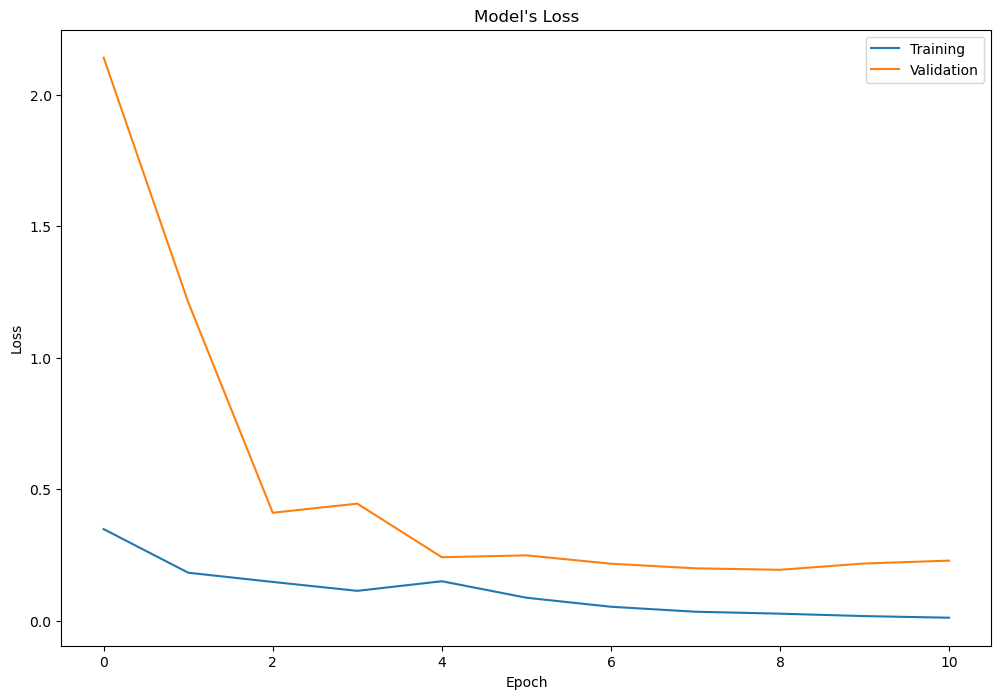

In [42]:
plt.figure(figsize=(12,8))
plt.plot(process.history["loss"])
plt.plot(process.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("Model's Loss")

plt.show();

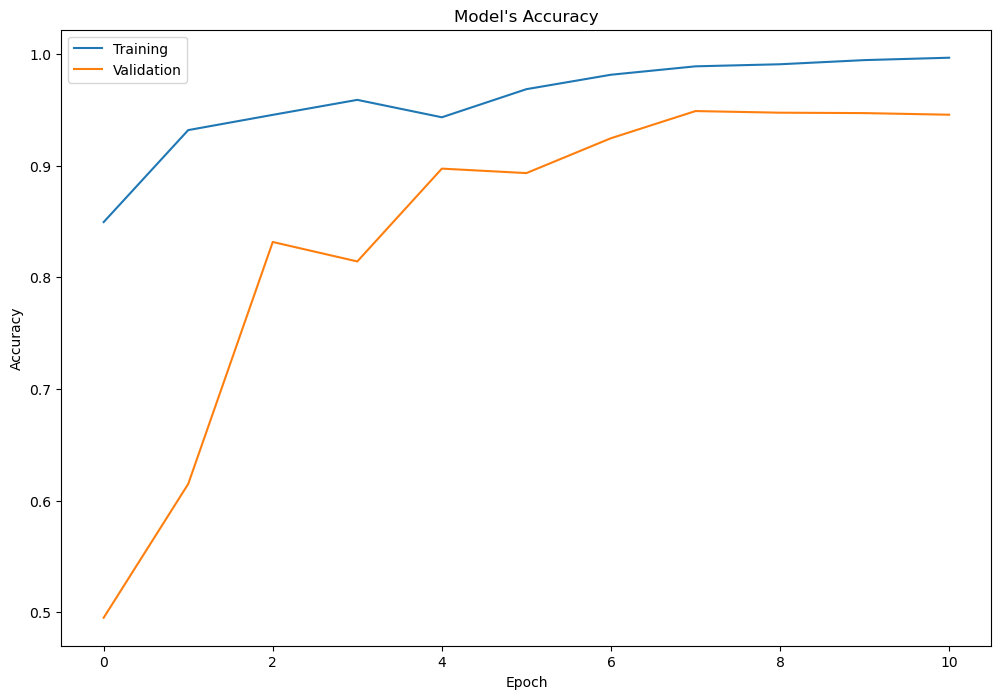

In [43]:
plt.figure(figsize=(12,8))
plt.plot(process.history["accuracy"])
plt.plot(process.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])
plt.title("Model's Accuracy")

plt.show();

## Model Evaluation and Testing

In [183]:
test_dataset = test_dataset.batch(1)

In [184]:
lenet_model_custom_layer.evaluate(test_dataset)

2756/2756 [==============================] - 32s 11ms/step - loss: 0.2549 - tp: 1278.0000 - tn: 1281.0000 - fn: 85.0000 - fp: 112.0000 - precision: 0.9194 - recall: 0.9376 - accuracy: 0.9285 - auc: 0.9715


[0.2548982799053192,
 1278.0,
 1281.0,
 85.0,
 112.0,
 0.9194244742393494,
 0.9376375675201416,
 0.928519606590271,
 0.9715180993080139]

### Confusion Matrix

Let's get our labels and predicted values to plot the confusion matrix

In [185]:
labels = []
input = []
for x, y in test_dataset.as_numpy_iterator():
    labels.append(y[0])
    input.append(x)

In [186]:
input = np.array(input)
input = input[:,0,...]
predicted = lenet_model_custom_layer.predict(input)
predicted = predicted[:,0]

print(predicted)
print(labels)

 8/87 [=>............................] - ETA: 0s 

2024-02-16 16:00:13.742495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 1s 9ms/step
[3.2650817e-03 2.6216108e-04 9.9784374e-01 ... 3.0668424e-03 9.9974400e-01
 9.9945933e-01]
[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 

Text(120.72222222222221, 0.5, 'True')

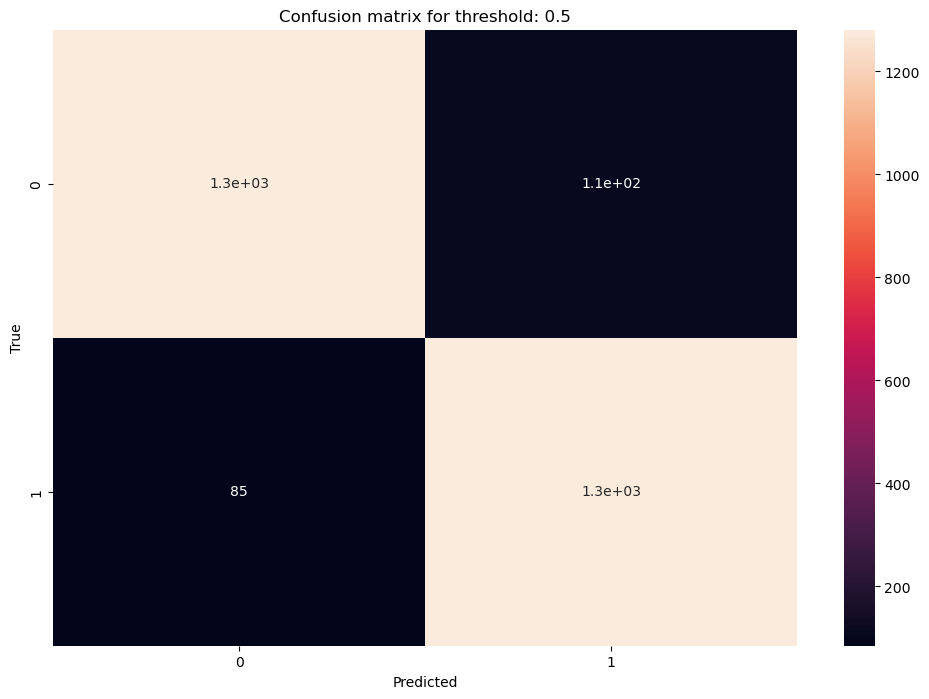

In [187]:
threshold = 0.5
cm = confusion_matrix(labels, predicted > threshold)
plt.figure(figsize=(12,8))

sns.heatmap(cm, annot=True)
plt.title(f"Confusion matrix for threshold: {threshold}")
plt.xlabel("Predicted")
plt.ylabel("True")

### ROC plot

In [188]:
fpr, tpr, thresholds = roc_curve(labels, predicted)
fpr_point = fpr[0: len(fpr): 20]
print(fpr.shape)
print(fpr_point.shape)

(315,)
(16,)


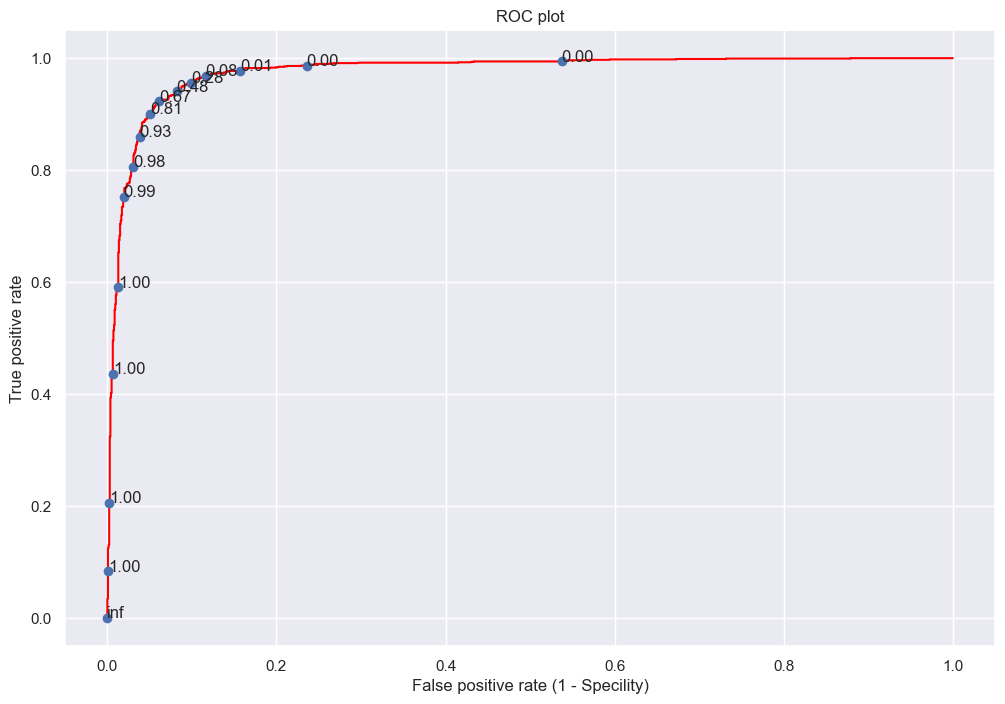

In [189]:
fpr, tpr, thresholds = roc_curve(labels, predicted)
plt.figure(figsize=(12,8))
sns.set_theme(style="dark")
plt.plot(fpr, tpr, color = "red", zorder = 1)
plt.title("ROC plot")
plt.xlabel("False positive rate (1 - Specility)")
plt.ylabel("True positive rate")

SKIP_STEP = 20
for i in range(0, len(thresholds), SKIP_STEP):
    plt.text(fpr[i], tpr[i], "{:.2f}".format(thresholds[i]))
fpr_points = fpr[0:len(fpr):SKIP_STEP]
tpr_points = tpr[0:len(tpr):SKIP_STEP]
plt.scatter(fpr_points, tpr_points)

plt.grid()

plt.show();

Text(117.24999999999999, 0.5, 'True')

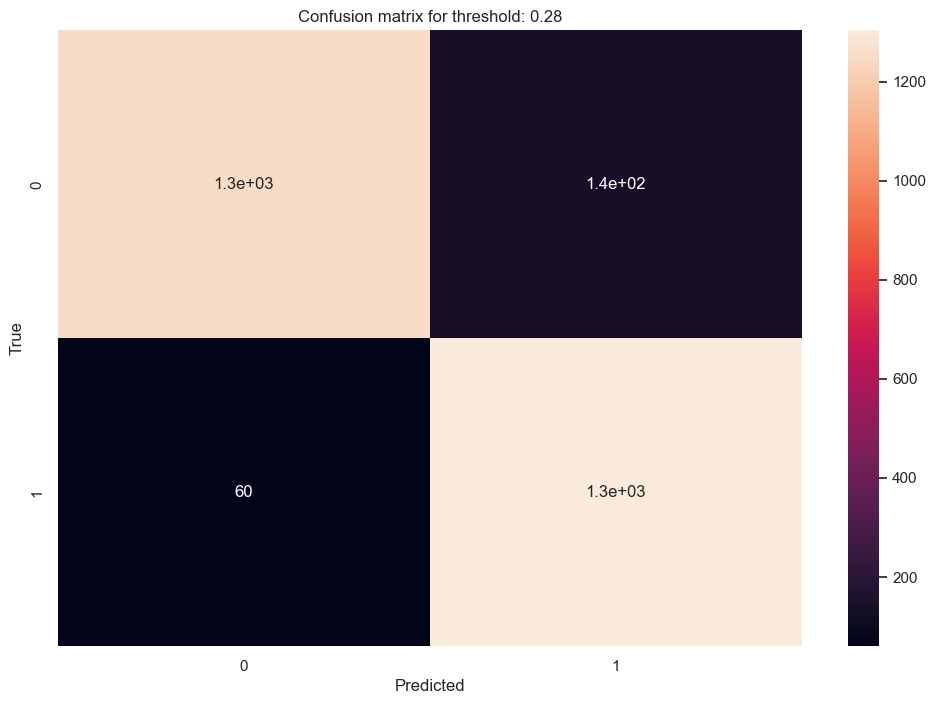

In [190]:
threshold = 0.28
cm = confusion_matrix(labels, predicted > threshold)
plt.figure(figsize=(12,8))

sns.heatmap(cm, annot=True)
plt.title(f"Confusion matrix for threshold: {threshold}")
plt.xlabel("Predicted")
plt.ylabel("True")

## Prediction

In [192]:
def parasite_or_not(x):
    if x>threshold:
        return "P"
    else:
        return "U"

In [193]:
parasite_or_not(lenet_model_custom_layer.predict(test_dataset.take(1))[0][0])

2024-02-16 16:01:35.769553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


'P'

1/1 [==============================] - 0s 10ms/step


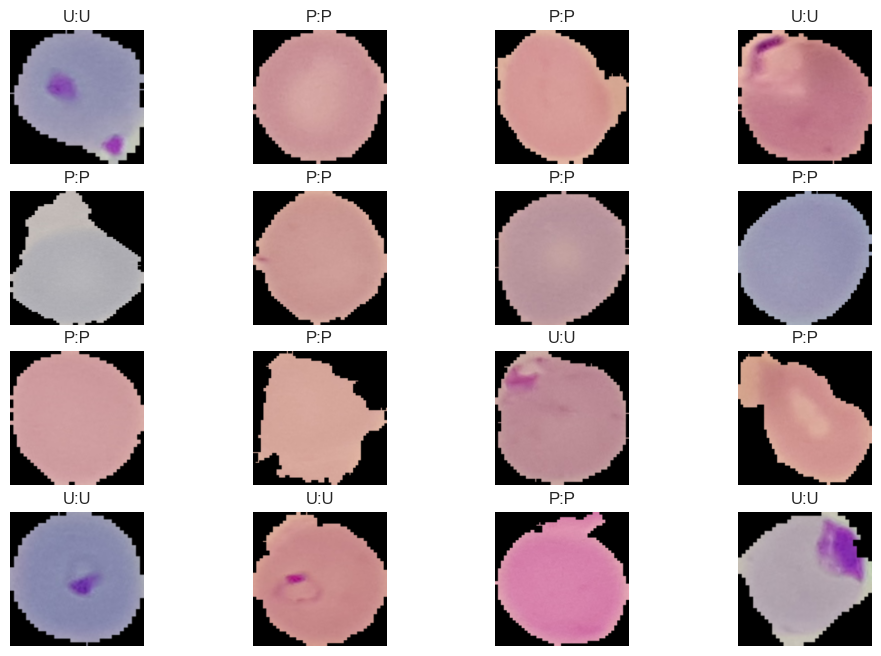

In [194]:
plt.figure(figsize=(12,8))
for i, (image, label) in enumerate(test_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image[0])
    plt.title(parasite_or_not(label.numpy()[0]) + ":" + parasite_or_not(lenet_model_custom_layer.predict(image)[0][0]))

    plt.axis("off")

## Saving our model

### Save the whole model

In [ ]:
# lenet_model_custom_layer.save("Malaria_Detection_whole")

# lenet_model_load = keras.models.load_model("Malaria_Detection_whole")

INFO:tensorflow:Assets written to: Malaria_Detection_whole/assets


INFO:tensorflow:Assets written to: Malaria_Detection_whole/assets


### Save only weights

In [ ]:
# lenet_model_custom_layer.save("Malaria_Detection_weights")

INFO:tensorflow:Assets written to: Malaria_Detection_weights/assets


INFO:tensorflow:Assets written to: Malaria_Detection_weights/assets
